<a href="https://colab.research.google.com/github/paulopestanaj/NLP_Ifood/blob/master/An%C3%A1lise_de_sentimento_do_aplicativo_Ifood_na_Play_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

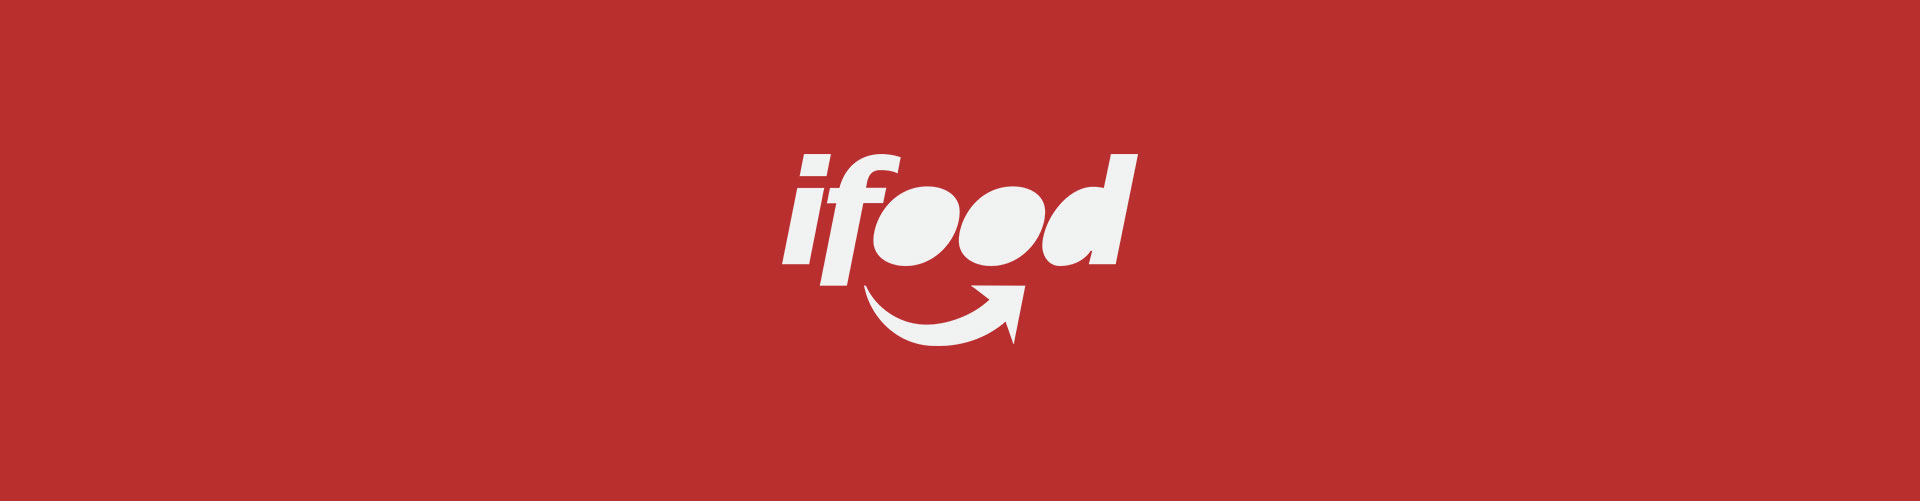

# Análise de sentimentos Ifood

O objetivo desse trabalho é analisar os comentários de um aplicativo na PlayStore e fazer uma classificação se são positivos ou negativos. Existe uma biblioteca chamada **google-play-scraper**, que com ela é possível fazer scrap dos comentários de qualquer aplicativo mais facilmente, vamos utiliza-lá nesse exemplo.

Nesse estudo de caso, eu escolhi o aplicativo do Ifood.



Dica: sempre leia a documentação das bibliotecas para melhorar seu desempenho e usabildidade.

Documentação da library: https://pypi.org/project/google-play-scraper/

Dito isso, vamos fazer a instalação.

In [1]:
pip install google-play-scraper

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-0.1.2-cp37-none-any.whl size=22280 sha256=53a2aa1082321356cb668dbeb79d52b5cea02483d8da2e127c2afcefa50552d0
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dc/847f7da787b7d2c28b26a5062f86eac3f16a8cb0bdfdc1f308
Successfully built google-play-scraper


In [2]:
#Importando todas as biblitoecas que utilizaremos

from google_play_scraper import app, Sort, reviews_all
import pandas as pd 
import numpy as np
import re
import nltk

from string import punctuation
import unicodedata
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

Agora precisamos escolher um aplicativo para podermos realizar o scrap dos comentário.
Nesse exemplo, como falando ateriromente, eu escolhi o aplicativo Ifood e para isso precisamos do id do app na Play Store.

Para obtermos o id, é só entrar no site Google Play Store, buscar o app que deseja e pegar o id na url gerada. 

Ex: https://play.google.com/store/apps/details?id=br.com.brainweb.ifood

Nesse caso o id do app é _**br.com.brainweb.ifood**_

Primeiramente, vamos usar a função _app_ para resgatar os dados do aplicativo, onde os parâmetros são:

- app_id = 'br.com.brainweb.ifood'
- lang = 'pt'
- country = 'br'

In [ ]:
ifood = app('br.com.brainweb.ifood', lang = 'pt', country = 'br')
ifood

O id do aplicativo retornou o aplicativo certo, então podemos dar continuidade.

Como queremos baixar os comentários, precisamos usar a função review_alls para conseguir realizar o scrap. Utilizando a função Sort, eu consigo filtrar pelos comentários mais relevantes.

Vamos procurar na documentação novamente para configurar nossos parâmetros.


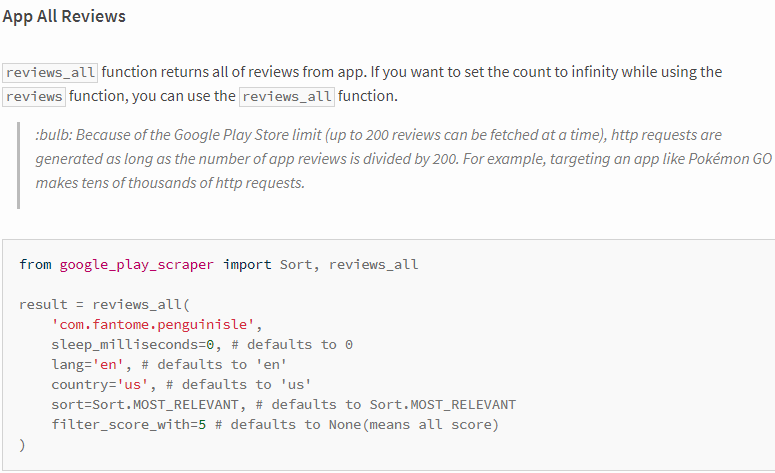

Vamos aplicar então no nosso caso, onde:

- app_id = 'br.com.brainweb.ifood'
- lang = 'pt'
- country = 'br'

Não preciso aplicar os outros filtros, pois por default, já trazem as condições que preciso.

Pode ser que demore um tempinho para realizar o scrap, portanto, não se preocupe.

In [ ]:
lista_comentarios = reviews_all( 'br.com.brainweb.ifood', 
                          lang = 'pt', 
                          country = 'br')


In [ ]:
len(lista_comentarios)

1005279

Podemos verificar que temos uma boa quantidade de comentários para realizarmos nossa classificação. 
Vamos transformar nossa lista em dataframe com a biblioteca Pandas.

In [ ]:
df_comentarios = pd.DataFrame(lista_comentarios)
df_comentarios.shape

(1005279, 10)

In [ ]:
df_comentarios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005228 entries, 0 to 1005278
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   reviewId              1005228 non-null  object        
 1   userName              1005228 non-null  object        
 2   userImage             1005228 non-null  object        
 3   content               1005228 non-null  object        
 4   score                 1005228 non-null  int64         
 5   thumbsUpCount         1005228 non-null  int64         
 6   reviewCreatedVersion  905089 non-null   object        
 7   at                    1005228 non-null  datetime64[ns]
 8   replyContent          1594 non-null     object        
 9   repliedAt             1594 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 84.4+ MB


Podemos ver que temos alguns comentários vazios, podemos verificar a quantidade de deletá-los da nossa base

In [ ]:
sum(df_comentarios['content'].isna())

1

In [ ]:
df_comentarios.dropna(subset=['content'], inplace = True)

In [ ]:
sum(df_comentarios['content'].isna())

0

In [ ]:
df_comentarios

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOEK5xCqZgFJtWGwNkAThHs77fPiAHX3Ut6a08Y...,Eloisa Miranda de C. Godinho,https://play-lh.googleusercontent.com/a-/AOh14...,ótimo,5,0,9.91.0,2021-02-28 17:58:09,NaN,NaN
1,gp:AOqpTOFzzuQJrQtqGXS_0uSHJoHIY25uy8C68J_DfU_...,Vicente Madeira,https://play-lh.googleusercontent.com/a-/AOh14...,Os parceiros atrasam muito e tem pouca ação ou...,3,0,9.91.0,2021-02-28 17:56:28,NaN,NaN
2,gp:AOqpTOHgZsVE9NSMSrGE0HLwKlKrAuWMiCl1ulboAAU...,Mari Sousa,https://play-lh.googleusercontent.com/-xhL2HNU...,ótimo,5,0,9.91.0,2021-02-28 17:53:01,NaN,NaN
3,gp:AOqpTOGXt5N4iS_pLK312ma1EoDJ9TPFV7O1hIC_jtF...,Maylla Silva,https://play-lh.googleusercontent.com/a-/AOh14...,Melhor App da vida!,5,0,9.91.0,2021-02-28 17:51:51,NaN,NaN
4,gp:AOqpTOGch6bdRKj_kmP1AOvM-D9q-Ls6OcVeRCnMVdj...,Gustavo Zatti,https://play-lh.googleusercontent.com/-NvA5FSh...,top,5,0,9.91.0,2021-02-28 17:50:07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1005223,lg:AOqpTOFPdn7oygOZx4DGZwV7A6vOjT4SeLOo9M7ua1y...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,Nao carrega o cep correto. Nao consegui cadast...,1,0,1.0,2012-05-19 23:18:20,NaN,NaN
1005224,lg:AOqpTOG9w47T7R_Bg4HA8SVEpPf9w6-Go_0pJp1OP3m...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,Rodou perfeitamente no meu Optimus Black. Aval...,5,0,1.0,2012-05-19 20:37:19,NaN,NaN
1005225,lg:AOqpTOH6qUko1x9umL6-b0knfT5PEtQwGbLTN39QZ0_...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Nada...Simplesmente não rolou...parece legal, ...",1,0,1.0,2012-05-19 00:15:42,NaN,NaN
1005226,lg:AOqpTOEctldwEnN1YBphJY0hoxdHtZxwcGgdwSQmn_A...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,Horrivel,1,0,1.0,2012-05-17 22:27:57,NaN,NaN


In [ ]:
df_comentarios.to_csv('/content/drive/MyDrive/ifood/ifood.csv', index = False)

# Lendo o Arquivo salvo

In [4]:
df_comentarios = pd.read_csv('/content/drive/MyDrive/ifood/ifood.csv')

In [5]:
df_comentarios.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOEK5xCqZgFJtWGwNkAThHs77fPiAHX3Ut6a08Y...,Eloisa Miranda de C. Godinho,https://play-lh.googleusercontent.com/a-/AOh14...,ótimo,5,0,9.91.0,2021-02-28 17:58:09,NaN,NaN
1,gp:AOqpTOFzzuQJrQtqGXS_0uSHJoHIY25uy8C68J_DfU_...,Vicente Madeira,https://play-lh.googleusercontent.com/a-/AOh14...,Os parceiros atrasam muito e tem pouca ação ou...,3,0,9.91.0,2021-02-28 17:56:28,NaN,NaN
2,gp:AOqpTOHgZsVE9NSMSrGE0HLwKlKrAuWMiCl1ulboAAU...,Mari Sousa,https://play-lh.googleusercontent.com/-xhL2HNU...,ótimo,5,0,9.91.0,2021-02-28 17:53:01,NaN,NaN
3,gp:AOqpTOGXt5N4iS_pLK312ma1EoDJ9TPFV7O1hIC_jtF...,Maylla Silva,https://play-lh.googleusercontent.com/a-/AOh14...,Melhor App da vida!,5,0,9.91.0,2021-02-28 17:51:51,NaN,NaN
4,gp:AOqpTOGch6bdRKj_kmP1AOvM-D9q-Ls6OcVeRCnMVdj...,Gustavo Zatti,https://play-lh.googleusercontent.com/-NvA5FSh...,top,5,0,9.91.0,2021-02-28 17:50:07,NaN,NaN


In [6]:
a = df_comentarios.sample(n=100000, random_state=42)

# Aplicando NLP com NLTK

---



In [ ]:
### TOKENIZAÇÃO DOS DADOS

a['content'] = a.apply(lambda row: nltk.word_tokenize(row['content']), axis=1) 

Agora vamos partir para o tratamento da coluna 'content' retirando as stopwords e as pontuações. 

## Stopwords

In [15]:
### Adicionando pontuação as stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords = list(set(stopwords))
stopwords = stopwords + list(punctuation)

- ## Normalizando os dados

In [16]:
def normalize(data):
  """ Normalise (normalize) unicode data in Python to remove umlauts, accents etc. """
  return unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')

In [17]:
def remover_stopwords(palavras):
    lista_palavras = []
    for palavra in palavras:
        if palavra not in stopwords:
            lista_palavras.append(palavra)
    return lista_palavras

In [18]:
def remover_pontuacao_e_modificar_lowercase(palavras):
  lista_palavras = []
  for palavra in palavras:
    nova_palavra = re.sub(r'[^\w\a]',"", palavra)
    if nova_palavra != "":
      lista_palavras.append(nova_palavra.lower())

  return lista_palavras


In [19]:
def normalizar(palavras):
    palavras = remover_pontuacao_e_modificar_lowercase(palavras)
    palavras = remover_stopwords(palavras)

    return ' '.join(palavras)

In [20]:
a['content_norm'] = a.apply(lambda row: normalizar(row['content']), axis=1)


In [21]:
a.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,content_norm
716433,gp:AOqpTOF-LM5pFCyZXqrdLtLN4KG_FPmZWMIkb-4i40t...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,[Ótimo],4,0,8.24.2,2018-12-14 21:38:47,NaN,NaN,ótimo
760451,gp:AOqpTOGV3OO3YrS5RNYymVsPmthB-UHky_gEcDD07bL...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,"[O, desenvolvedor, desse, App, foi, muito, gra...",5,0,8.21.1,2018-10-13 00:26:47,NaN,NaN,desenvolvedor desse app grandiosamente intelig...
599759,gp:AOqpTOGhJmGyF3gI5Y8bfAC8kYXLHBXtDoad9Iyjui2...,Singrid Luz,https://play-lh.googleusercontent.com/a-/AOh14...,"[Não, há, opção, de, cancelamento, ., Fiz, um,...",1,0,8.39.2,2019-03-31 16:31:10,NaN,NaN,opção cancelamento fiz pedido instante quis ca...
197723,gp:AOqpTOGLlViAT_-Ywyze4l0HFxh26caTAoCN68ijzTN...,Heldon Pinheiro,https://play-lh.googleusercontent.com/a-/AOh14...,"[Maravilhoso, esse, app]",5,0,9.60.1,2020-07-22 22:36:12,NaN,NaN,maravilhoso app
67533,gp:AOqpTOH4NhMywFu40r1nydVp2u_yFDAm_-udBNfAfo-...,Carlos Ribeiro,https://play-lh.googleusercontent.com/-ZXdme6s...,"[Muito, prático]",5,0,9.80.1,2020-12-12 22:32:46,NaN,NaN,prático


## Sentilex-PT

SentilexPT é um léxico para o idioma Português que possui 6531 adjetivos com informações de polaridade, alvo do
sentimento e método de atribuição de polaridade.

Veja que temos as palavras, em seguida temos tipo (PoS=Adj) isso significa que é um Adjetivo, Gênero (GN), o alvo do
sentimento (TG=HUM) onde “HUM” significa que o alvo para pessoas, a polaridade (POL) que pode ser 1 ou -1 ou 0,
onde 1 significa positivo, -1 significa negativo e 0 significa neutro, e a forma que esta polaridade foi atribuída (ANOT onde
“MAN” significa que a polaridade foi atribuída de forma manual, ou seja, não foi automática.


> O arquivo pode ser encontrado [aqui](http://b2find.eudat.eu/dataset/b6bd16c2-a8ab-598f-be41-1e7aeecd60d3).

In [22]:
#Importando o Léxico de Palavras com polaridades
sentilexpt = open('/content/drive/MyDrive/ifood/SentiLex-lem-PT02.txt')

In [23]:
#Criando um dicionário de palavras com a respectiva polaridade.

dic_palavra_polaridade = {}

for i in sentilexpt.readlines():
  pos_ponto = i.find('.')
  palavra = (i[:pos_ponto])
  palavra = normalize(palavra).decode('utf-8')
  pol_pos = i.find('POL')
  polaridade = (i[pol_pos+7:pol_pos+9]).replace(';', '')
  
  dic_palavra_polaridade[palavra] = polaridade

In [24]:
#Verificando o dicionário

dic_palavra_polaridade

{'a-vontade': '1',
 'abafado': '-1',
 'abafante': '-1',
 'abaixado': '-1',
 'abalado': '-1',
 'abalizado': '1',
 'abalroado': '-1',
 'abalroar': '1',
 'abanar': '1',
 'abandalhado': '-1',
 'abandalhamento': '-1',
 'abandonado': '-1',
 'abandonar': '-1',
 'abarcante': '0',
 'abarrotado': '-1',
 'abastado': '1',
 'abastecido': '0',
 'abater': '1',
 'abatido': '-1',
 'abelhudo': '-1',
 'abencoado': '1',
 'aberracao': '-1',
 'aberrante': '-1',
 'aberrativo': '-1',
 'aberto': '1',
 'abespinhado': '-1',
 'abestalhado': '-1',
 'abilolado': '-1',
 'abjecao': '-1',
 'abjeccao': '-1',
 'abjecto': '-1',
 'abjeto': '-1',
 'abnegado': '1',
 'abobado': '-1',
 'abobalhado': '-1',
 'abolicionista': '0',
 'abolido': '-1',
 'abominador': '-1',
 'abominando': '-1',
 'abominar': '0',
 'abominavel': '-1',
 'abonado': '1',
 'abonatorio': '1',
 'abonecado': '0',
 'aborrecer-se': '-1',
 'aborrecer': '1',
 'aborrecido': '-1',
 'abortado': '-1',
 'abracado': '1',
 'abrasileirado': '0',
 'abrigado': '0',
 'abril

In [25]:
#Criando uma função chamada "Score de Sentimento" para determinar os sentimentos associados
def Score_sentimento(frase):
    frase = frase.lower()
    l_sentimento = []
    for p in frase.split():
        l_sentimento.append(int(dic_palavra_polaridade.get(p, 0)))
    score = sum(l_sentimento)
    if score > 0:
        return 'Pos {} '.format(score)
    elif score == 0:
        return 'Neu {} '.format(score)
    else:
        
        return 'Neg {}'.format(score)

In [26]:
#Criando uma função para aplicar um score de sentimento para cada um dos comentários, a partir das palavras positivas e negativas.
a['sentimento'] = a.apply(lambda row: Score_sentimento(row['content_norm']), axis=1)

In [27]:
a.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,content_norm,sentimento
716433,gp:AOqpTOF-LM5pFCyZXqrdLtLN4KG_FPmZWMIkb-4i40t...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,[Ótimo],4,0,8.24.2,2018-12-14 21:38:47,NaN,NaN,ótimo,Neu 0
760451,gp:AOqpTOGV3OO3YrS5RNYymVsPmthB-UHky_gEcDD07bL...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,"[O, desenvolvedor, desse, App, foi, muito, gra...",5,0,8.21.1,2018-10-13 00:26:47,NaN,NaN,desenvolvedor desse app grandiosamente intelig...,Pos 1
599759,gp:AOqpTOGhJmGyF3gI5Y8bfAC8kYXLHBXtDoad9Iyjui2...,Singrid Luz,https://play-lh.googleusercontent.com/a-/AOh14...,"[Não, há, opção, de, cancelamento, ., Fiz, um,...",1,0,8.39.2,2019-03-31 16:31:10,NaN,NaN,opção cancelamento fiz pedido instante quis ca...,Neu 0
197723,gp:AOqpTOGLlViAT_-Ywyze4l0HFxh26caTAoCN68ijzTN...,Heldon Pinheiro,https://play-lh.googleusercontent.com/a-/AOh14...,"[Maravilhoso, esse, app]",5,0,9.60.1,2020-07-22 22:36:12,NaN,NaN,maravilhoso app,Pos 1
67533,gp:AOqpTOH4NhMywFu40r1nydVp2u_yFDAm_-udBNfAfo-...,Carlos Ribeiro,https://play-lh.googleusercontent.com/-ZXdme6s...,"[Muito, prático]",5,0,9.80.1,2020-12-12 22:32:46,NaN,NaN,prático,Neu 0


In [28]:
#Separando o categorico do valor do sentimento

a['Score_Sentimento'] = a['sentimento'].str.slice(-3)
a['Score_Sentimento'] = a['Score_Sentimento'].astype(int)
a['Sent'] = a['sentimento'].str.slice(0,-3).str.strip(" ")

In [29]:
a.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,content_norm,sentimento,Score_Sentimento,Sent
716433,gp:AOqpTOF-LM5pFCyZXqrdLtLN4KG_FPmZWMIkb-4i40t...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,[Ótimo],4,0,8.24.2,2018-12-14 21:38:47,NaN,NaN,ótimo,Neu 0,0,Neu
760451,gp:AOqpTOGV3OO3YrS5RNYymVsPmthB-UHky_gEcDD07bL...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,"[O, desenvolvedor, desse, App, foi, muito, gra...",5,0,8.21.1,2018-10-13 00:26:47,NaN,NaN,desenvolvedor desse app grandiosamente intelig...,Pos 1,1,Pos
599759,gp:AOqpTOGhJmGyF3gI5Y8bfAC8kYXLHBXtDoad9Iyjui2...,Singrid Luz,https://play-lh.googleusercontent.com/a-/AOh14...,"[Não, há, opção, de, cancelamento, ., Fiz, um,...",1,0,8.39.2,2019-03-31 16:31:10,NaN,NaN,opção cancelamento fiz pedido instante quis ca...,Neu 0,0,Neu
197723,gp:AOqpTOGLlViAT_-Ywyze4l0HFxh26caTAoCN68ijzTN...,Heldon Pinheiro,https://play-lh.googleusercontent.com/a-/AOh14...,"[Maravilhoso, esse, app]",5,0,9.60.1,2020-07-22 22:36:12,NaN,NaN,maravilhoso app,Pos 1,1,Pos
67533,gp:AOqpTOH4NhMywFu40r1nydVp2u_yFDAm_-udBNfAfo-...,Carlos Ribeiro,https://play-lh.googleusercontent.com/-ZXdme6s...,"[Muito, prático]",5,0,9.80.1,2020-12-12 22:32:46,NaN,NaN,prático,Neu 0,0,Neu


Podemos visualizar a contagem de valores para ter uma noção de como o score separou os comentários.

In [30]:
a.groupby('Score_Sentimento').count()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,content_norm,sentimento,Sent
Score_Sentimento,,,,,,,,,,,,,
-13,1,1,1,1,1,1,1,1,0,0,1,1,1
-8,1,1,1,1,1,1,1,1,0,0,1,1,1
-7,3,3,3,3,3,3,3,3,0,0,3,3,3
-6,7,7,7,7,7,7,5,7,0,0,7,7,7
-5,12,12,12,12,12,12,9,12,1,1,12,12,12
-4,82,82,82,82,82,82,69,82,1,1,82,82,82
-3,269,269,269,269,269,269,227,269,2,2,269,269,269
-2,1051,1051,1051,1051,1051,1051,888,1051,8,8,1051,1051,1051
-1,5972,5972,5972,5972,5972,5972,5176,5972,28,28,5972,5972,5972


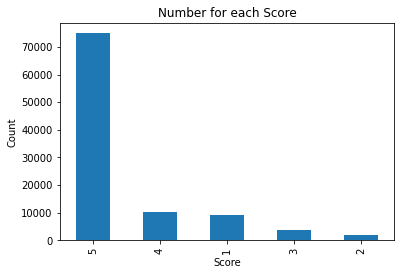

In [31]:
series = a['score'].value_counts()
ax = series.plot(kind='bar', title='Number for each Score')
ax.set_xlabel('Score')
ax.set_ylabel('Count')
plt.show()

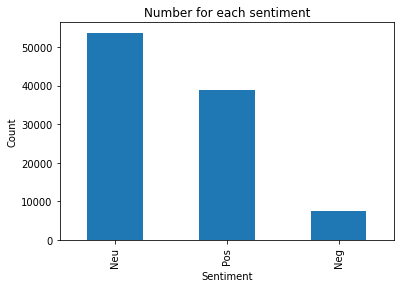

In [32]:
series = a['Sent'].value_counts()
ax = series.plot(kind='bar', title='Number for each sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

## Pré processamento.

Modelos geralmente não processam dados que não sejam variáveis numéricas, e como nossas variáveis são textuais, podemos transformar em vetor.

Posso usar o CountVectorizer que transforma cada um dos tokens que foram criados em um valor númerico.

In [56]:
# Vetorização (Converter texto e números).
vectorizer = CountVectorizer(max_features=1000)                
data_features = vectorizer.fit_transform(a['content_norm'])

data_features = data_features.toarray()

score = a['score'].values

Com isso, a minha coluna dos comentários normalizados foram processadas e transformadas em vetor.

Feito todo o processamento, eu vou abordar esse problema de duas maneiras.

A primeira, vou utilizar a nota que os usuários deram no aplicativo para tentar classificar novos conjuntos e aplicar no meu modelo.

A segunda, vou utilizar o dicionário léxico.

O modelo a ser utilizado para ambos os casos será o RandomForest.

# Abordagem 01

- Objetivo: Utilizar os comentários para prever qual nota o usuário deu para o aplicativo na PlayStore.
- Variáveis preditoras: content_norm
- Target: score
- Model: RandomForest
- Metric: accuracy

In [57]:
# Split data into training and testing set.

X_train_01, X_test_01, y_train_01, y_test_01 = train_test_split(data_features, score, test_size=0.3, random_state=42)

In [58]:
data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [59]:
score

array([4, 5, 1, ..., 5, 4, 5])

### Separando o modelo

Random Forest

O Random Forest é um algoritmo que usa diversas árvores de decisão limitadas a uma pequena porção do train set. Ele basicamente pega um pedaço aleatório do train set e avalia. Com esses múltiplos pedaços, ele chega numa resposta balanceada dos parâmetros.

Com isso, ele cria uma série de preditores fracos para chegar num preditor forte.

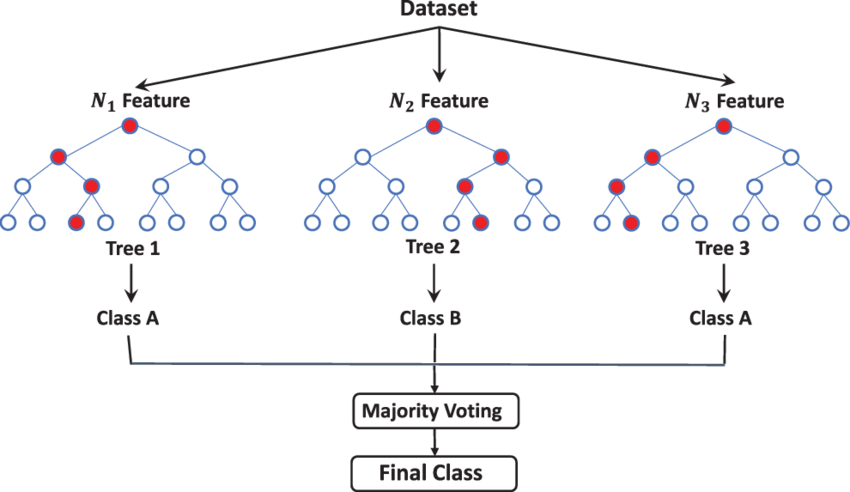

In [60]:
# Usando Random Forest para classificar os reviews.

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)


forest = forest.fit(X_train_01, y_train_01)


print(forest)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


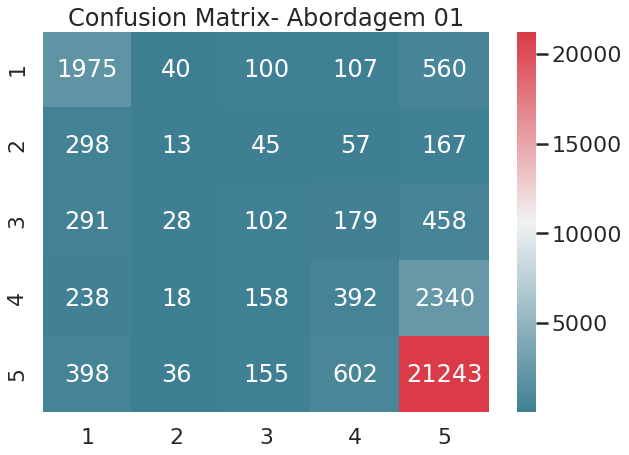

In [61]:
result = forest.predict(X_test_01)

sns.set("poster")
sns.set_style('whitegrid')
conf_mat = confusion_matrix(y_test_01, result)
cmap = sns.diverging_palette(220, 10, as_cmap = True)


df_cm = pd.DataFrame(conf_mat, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))


sns.heatmap(df_cm,cmap=cmap, annot=True, fmt='g').set_title('Confusion Matrix- Abordagem 01');

No eixo x, de 1 a 5, são as avaliações observadas no test set.

No eixo y, de 1 a 5 são as previsões que o modelo fez.

Ex:

Na posição da matriz 1x1, mostra quantas vezes o modelo previu que seria 1 e de fato o score era 1. Ou seja, o modelo acertou.

Já na posição 1x2, o modelo previu que que o score seria 2, mas na verdade era 1. Ou seja, o modelo errou.

Conseguimos perceber que esse o modelo é bem bom para prever nota 1 e nota 5, porém para as outras ele não é tão bom.

In [62]:
accuracy_score(y_test_01, result)

0.7908333333333334

Para entender esse resultado, melhor dar uma revisada nos conceitos:

- True positive (TP) : significa uma classificação correta da classe positive. Por exemplo, a classe real é Positivo e o modelo classificou como Positivo.

- True negative (TN) : significa uma classificação correta da classe negative. Por exemplo, a classe real é Negativo e o modelo classificou como Negativo.

- False positive (FP) : significa uma classificação errada da classe positive. Por exemplo, a classe real é Negativo e o modelo classificou como Positivo.

- False negative (FN) : significa uma classificação errada da classe negative. Por exemplo, a classe real é Positivo e o modelo classificou como Negativo.

A acurácia (accuracy) é calculada da seguinte forma:

`Accuracy = (TP +TN ) / (TP + FP +TN +FN)`

Isso da uma ideia de como o modelo funciona de forma geral.

# Abordagem 2

- Objetivo: Colocar novas variáveis e nosso dicionário léxico, além dos comentários para prever se o score do usuário.

- Variáveis preditoras: 
  - content_norm: Comentário normalizado
  - reviewCreatedVersion: Versão do app
  - thumbsUpCount: Likes
  - Sent: Sentimento (POS, NEU, NEG)
  - at: Data do review
- Target: score
- Model: RandomForest
- Metric: accuracy

Nesse ponto, vou vetorizar todas as novas variaveis e concatenar num novo dataframe

In [37]:
X_02 = a['content_norm']
y_02 = a['score']

#Fazendo um novo split
X_train, X_test, y_train, y_test = train_test_split(X_02, y_02, test_size = 0.3, random_state = 42)


In [38]:
cvec = CountVectorizer(max_features = 1000).fit(X_train)

#Vamos chamar o primeiro train set de df_train
df_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
df_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

print(df_train.shape)
print(y_train.shape)
print(df_test.shape)
print(y_test.shape)

(70000, 1000)
(70000,)
(30000, 1000)
(30000,)


In [42]:
df_train.head()

,10,100,1000,15,20,25,30,40,50,aberto,abre,abrir,absurdo,acaba,acabei,acabou,aceita,aceitam,aceitando,aceitar,aceito,aceitou,acessar,acesso,acessível,acha,achar,achei,acho,acima,acompanhamento,acompanhar,acontece,aconteceu,acordo,acredito,adianta,adicionar,adorando,adorei,...,vc,vcs,veio,vejo,vem,ver,verdade,vergonha,versão,vez,vezes,vi,via,vida,vidas,visa,viu,vivo,volta,voltar,vontade,vou,válido,várias,vários,vão,youtube,zero,ágil,área,ótima,ótimas,ótimo,ótimos,última,último,últimos,única,único,útil
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Esta etapa está transformando os dados em matriz e colocando em um dataframe.

Vou realizar esse mesmo processo para cada nova variável.

## Inserindo versão do app

In [46]:
X = a['reviewCreatedVersion'].apply(str)
y = a['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
cvec = CountVectorizer(max_features = 1000).fit(X_train)

version_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
version_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

## Inserindo os likes

In [47]:
X = a['thumbsUpCount'].apply(str)
y = a['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
cvec = CountVectorizer(max_features = 1000).fit(X_train)

thumbs_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
thumbs_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

## Inserindo sentimentos

In [48]:
X = a['Sent'].apply(str)
y = a['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
cvec = CountVectorizer(max_features = 1000).fit(X_train)

sent_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
sent_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

## Inserindo a data

In [49]:
X = a['at'].apply(str)
y = a['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

cvec = CountVectorizer(max_features = 1000).fit(X_train)
at_train = pd.DataFrame(cvec.transform(X_train).todense(), columns = cvec.get_feature_names())
at_test = pd.DataFrame(cvec.transform(X_test).todense(), columns=cvec.get_feature_names())

## Concatenando todas as inserções em um único DF

In [50]:
train = pd.concat ([df_train, sent_train, thumbs_train, version_train, at_train], axis = 1)
test = pd.concat([df_test, sent_test, thumbs_test, version_test, at_test], axis = 1)

print(train.shape)
print(test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 1286)
(30000, 1286)
(70000,)
(30000,)


### Aplicando o modelo

In [51]:
forest_02 = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest_02 = forest_02.fit(train, y_train)
print(forest_02)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


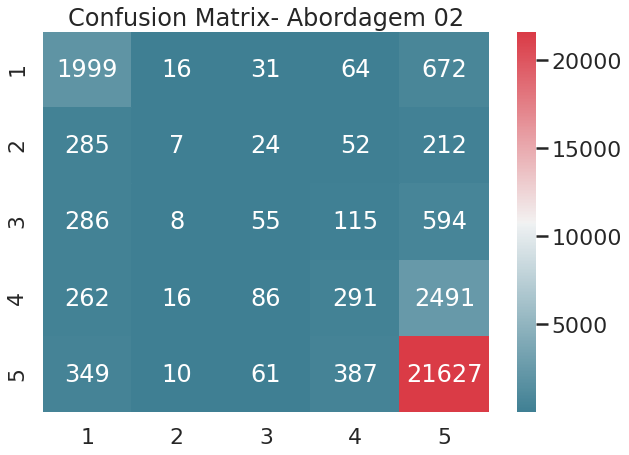

In [53]:
result_02 = forest_02.predict(test)

sns.set("poster")
sns.set_style('whitegrid')
conf_mat = confusion_matrix(y_test, result_02)
cmap = sns.diverging_palette(220, 10, as_cmap = True)


df_cm = pd.DataFrame(conf_mat, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))


sns.heatmap(df_cm,cmap=cmap, annot=True, fmt='g').set_title('Confusion Matrix- Abordagem 02');

In [54]:
accuracy_score(y_test, result_02)

0.7993

In [63]:
print('A acurácia da abordagem 01 é: '+str(accuracy_score(y_test_01, result)))
print('A acurácia da abordagem 02 é: '+str(accuracy_score(y_test, result_02)))

A acurácia da abordagem 01 é: 0.7908333333333334
A acurácia da abordagem 02 é: 0.7993


# Conclusão

Podemos ver que nossa acurácia não melhorou muito com a inclusão de novas variáveis e do nosso dicionário léxico. 

Para uma melhoria efetiva do nosso modelo, talvez seja necessária uma melhoria no nosso dicionário, uma melhor higienização dos dados para evitar palavras com erros de digitação ou gírias não captadas. 

Devido a complexidada de abordagem 02, e uma acurácia não tão mais efetivida, opto pela aplicação da abordagem 01 para esse problema.